In [1]:
import json
import os
import random
import sys

import matplotlib.pyplot as plt
import torch
from nnsight import CONFIG, LanguageModel
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils import (
    error_detection,
    get_answer_lookback_payload,
    get_reversed_sent_diff_state_counterfacts,
)

current_dir = os.getcwd()
sys.path.append(os.path.dirname(os.path.dirname(current_dir)))
from src import global_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(10)

CONFIG.APP.REMOTE_LOGGING = False
CONFIG.set_default_api_key(global_utils.load_env_var("NDIF_KEY"))
os.environ["HF_TOKEN"] = global_utils.load_env_var("HF_WRITE")

%load_ext autoreload

/disk/u/nikhil/mind/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Characters, Objects, and States

In [2]:
all_characters = json.load(
    open(
        os.path.join(global_utils.DATA_DIR, "synthetic_entities", "characters.json"),
        "r",
    )
)
all_objects = json.load(
    open(
        os.path.join(global_utils.DATA_DIR, "synthetic_entities", "bottles.json"),
        "r",
    )
)
all_states = json.load(
    open(
        os.path.join(global_utils.DATA_DIR, "synthetic_entities", "drinks.json"),
        "r",
    )
)

print(f"#characters: {len(all_characters)}")
print(f"#objects: {len(all_objects)}")
print(f"#states: {len(all_states)}")

#characters: 103
#objects: 21
#states: 23


# Load Model

In [ ]:
is_remote = False

if is_remote:
    model = LanguageModel("meta-llama/Llama-3.1-405B-Instruct")
else:
    model = LanguageModel(
        "meta-llama/Meta-Llama-3-70B-Instruct",
        device_map="auto",
        dtype=torch.float16,
        dispatch=True,
    )

`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


# Pointer (Fig 4 in the paper)

In [16]:
n_samples = 20
batch_size = 1

dataset = get_reversed_sent_diff_state_counterfacts(
    all_characters,
    all_objects,
    all_states,
    n_samples,
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [17]:
idx = 0
print("COUNTERFACTUAL EXAMPLE")
print("=" * 25)
print(dataset[idx]["counterfactual_prompt"], dataset[idx]["counterfactual_ans"])
print()

print("CLEAN EXAMPLE")
print("=" * 25)
print(dataset[idx]["clean_prompt"], dataset[idx]["clean_ans"])
print(f"\nTarget: {dataset[idx]['target']}")

COUNTERFACTUAL EXAMPLE
Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any beliefs about the container and its contents which they cannot observe. 4. To answer the question, predict only what is inside the queried container, strictly based on the belief of the character, mentioned in the question. 5. If the queried character has no belief about the container in question, then predict 'unknown'. 6. Do not predict container or character as the final output.

Story: Rick and Pete are working in a busy restaurant. To complete an order, Rick grabs an opaque bottle and fills it with tea. Then Pete grabs another opaque tun and fills it with milk.
Question: What does Rick believe the bottle contains?
Answer: tea

CLEAN EXAMPLE
Instruction: 1. Track the belief of each character as described in the story. 2. A character's

In [18]:
_, errors = error_detection(model, dataloader, is_remote)
print(
    f"Dataset size to be used for IIA: {len(dataset) - len(errors)} ({len(errors)} errors)"
)

100%|██████████| 20/20 [00:06<00:00,  2.88it/s]

Dataset size to be used for IIA: 20 (0 errors)


In [ ]:
accs_answer_lookback_pointer = {}
patch_layers = (
    [i for i in range(0, 30, 10)]
    + [i for i in range(32, 62, 2)]
    + [i for i in range(70, model.config.num_hidden_layers, 10)]
)

for layer_idx in patch_layers:
    correct, total = 0, 0
    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        if bi in errors:
            continue
        counterfactual_prompt = batch["counterfactual_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]

        with torch.no_grad():
            with model.trace(counterfactual_prompt):
                counterfactual_layer_out = (
                    model.model.layers[layer_idx].output[0, -1].save()
                )

            with model.trace(clean_prompt):
                model.model.layers[layer_idx].output[0, -1] = counterfactual_layer_out
                pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

            if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
                correct += 1
            total += 1

            del pred
            torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_answer_lookback_pointer[layer_idx] = acc

100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Layer: 0 | Accuracy: 0.0


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Layer: 10 | Accuracy: 0.0


100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Layer: 20 | Accuracy: 0.0


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Layer: 32 | Accuracy: 0.15


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Layer: 34 | Accuracy: 1.0


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Layer: 36 | Accuracy: 0.95


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Layer: 38 | Accuracy: 1.0


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Layer: 40 | Accuracy: 0.95


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Layer: 42 | Accuracy: 0.95


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Layer: 44 | Accuracy: 0.95


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Layer: 46 | Accuracy: 0.95


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Layer: 48 | Accuracy: 0.95


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Layer: 50 | Accuracy: 0.95


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Layer: 52 | Accuracy: 0.85


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Layer: 54 | Accuracy: 0.7


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Layer: 56 | Accuracy: 0.15


100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Layer: 58 | Accuracy: 0.05


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Layer: 60 | Accuracy: 0.0


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]

Layer: 70 | Accuracy: 0.0


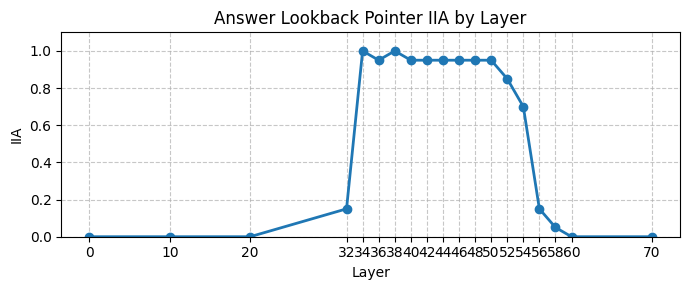

In [23]:
# Visualize accs_binding_addr_and_payload as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_answer_lookback_pointer.keys())
accuracies = list(accs_answer_lookback_pointer.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Answer Lookback Pointer IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Payload (Fig 4 in the paper)

In [24]:
n_samples = 10
batch_size = 1

dataset = get_answer_lookback_payload(
    all_characters,
    all_objects,
    all_states,
    n_samples,
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [25]:
idx = 0
print("COUNTERFACTUAL EXAMPLE")
print("=" * 25)
print(dataset[idx]["counterfactual_prompt"], dataset[idx]["counterfactual_ans"])
print()

print("CLEAN EXAMPLE")
print("=" * 25)
print(dataset[idx]["clean_prompt"], dataset[idx]["clean_ans"])
print(f"\nTarget: {dataset[idx]['target']}")

COUNTERFACTUAL EXAMPLE
Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any beliefs about the container and its contents which they cannot observe. 4. To answer the question, predict only what is inside the queried container, strictly based on the belief of the character, mentioned in the question. 5. If the queried character has no belief about the container in question, then predict 'unknown'. 6. Do not predict container or character as the final output.

Story: Charlie and Mark are working in a busy restaurant. To complete an order, Charlie grabs an opaque quart and fills it with rum. Then Mark grabs another opaque pitcher and fills it with milk.
Question: What does Mark believe the pitcher contains?
Answer: milk

CLEAN EXAMPLE
Instruction: 1. Track the belief of each character as described in the story. 2. A 

In [26]:
_, errors = error_detection(model, dataloader, is_remote)
print(
    f"Dataset size to be used for IIA: {len(dataset) - len(errors)} ({len(errors)} errors)"
)

100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

Dataset size to be used for IIA: 8 (2 errors)


In [ ]:
accs_answer_lookback_payload = {}
patch_layers = [i for i in range(0, 60, 10)] + [
    i for i in range(52, model.config.num_hidden_layers, 2)
]

for layer_idx in patch_layers:
    correct, total = 0, 0
    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        if bi in errors:
            continue
        counterfactual_prompt = batch["counterfactual_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]

        with torch.no_grad():
            with model.trace(counterfactual_prompt, remote=is_remote):
                counterfactual_layer_out = (
                    model.model.layers[layer_idx].output[0, -1].save()
                )

            with model.trace(clean_prompt, remote=is_remote):
                model.model.layers[layer_idx].output[0, -1] = counterfactual_layer_out
                pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

        if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
            correct += 1
        total += 1

        del pred
        torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_answer_lookback_payload[layer_idx] = acc

100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Layer: 0 | Accuracy: 0.0


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 10 | Accuracy: 0.0


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 20 | Accuracy: 0.0


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 30 | Accuracy: 0.0


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 40 | Accuracy: 0.0


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 50 | Accuracy: 0.0


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 52 | Accuracy: 0.0


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 54 | Accuracy: 0.25


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 56 | Accuracy: 0.75


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 58 | Accuracy: 0.88


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 60 | Accuracy: 0.88


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 62 | Accuracy: 0.88


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 64 | Accuracy: 1.0


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 66 | Accuracy: 1.0


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 68 | Accuracy: 1.0


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 70 | Accuracy: 1.0


100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Layer: 72 | Accuracy: 1.0


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 74 | Accuracy: 1.0


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Layer: 76 | Accuracy: 1.0


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]

Layer: 78 | Accuracy: 1.0


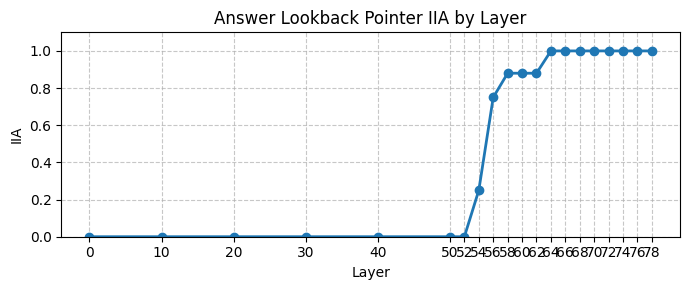

In [29]:
# Visualize accs_binding_addr_and_payload as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_answer_lookback_payload.keys())
accuracies = list(accs_answer_lookback_payload.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Answer Lookback Pointer IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()